In [1]:
# import package
import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import cm, ticker


In [2]:
#  set parameters

#  work path
wd_ = 'D:\\sheared_granular_gouge_different_evironment_condition\\k\\80k\\PythonFile_CalculateGranularQuantity'
condition_ = '80k_1p5'

#%% define index to be calculated
index_former_ = [376]
index_later_ = [456]
if len(index_former_) != len(index_later_):
    print('The program terminated!!!\nThe size of \'index_former\' and \'index_later\' is not the same')
    sys.exit()
    
# set the mesh grid
precision_ = 100
x_lol_ = 0.5e-3 # lower limit of x
x_upl_ = 3.5e-3 # upper limit of x
y_lol_ = 1e-3 # lower limit of y
y_upl_ = 3e-3 # upper limit of y
xx_ = np.linspace(x_lol_,x_upl_, num = 2 * precision_)
yy_ = np.linspace(y_lol_,y_upl_, num = precision_)
grid_xx_, grid_yy_ = np.meshgrid(xx_, yy_)

# set the plot parameter
vmax_ = 10e2
vmin_ = 10e-5

# set the translate threshold
thresh_trans_ = 0

# set the average layers
n_layers_ = 15

# set the filter extrem threshold
thresh_ = float('Inf')

# change wd and import functions
#%% change current directory
os.chdir(wd_)
# import functions
from import_data import *

In [3]:
#%% Screen particles according to x to avoid effects caused by BC
def screen_grains_by_x(l_lim_, u_lim_, c_, v_):
    '''
    l_lim_ - lower limit
    u_lim_ - upper limit
    c_ - c coodinate
    v_ - corresponding variables
    
    returns:
        cnew_ - the  coodinate in a centain range
        vnew_ - the correspnding coodinate in a certain range
    
    '''
    cnew_, vnew_ = [], [] # initialize
    for i_ in range(c_.shape[0]):
        
        if c_[i_][0] > l_lim_ and c_[i_][0]  < u_lim_:
            cnew_.append(c_[i_][:])
            vnew_.append(v_[i_])

    return np.array(cnew_), np.array(vnew_)  # return handled coodinate and variables.

# cnew_, ynew_ = screen_grains_by_x(0.5, 3.5, x_, y_)
# cnew_, vnew_ = screen_grains_by_x(0.5, 3.5, x_, vx_)



Read nonaffine from 376 to 456 done


Reading particle info 376...
Index(['ID', ' cx', ' cy', ' dx', ' dy', ' vx', ' vy', ' Cxx', ' Cxy', ' Cyy'], dtype='object')

Read particle info 376 successful

Read coordinate done


Interpolation done



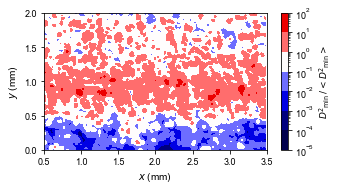


-----------------------------------------------------


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [4]:
#%% start the calculation
steps_ = len(index_former_)
for i_ in range(steps_):
    # import data
    nonaffine_ = np.load('D:/sheared_granular_gouge_different_evironment_condition/python_nonaffine_displacement_data/nonaffine_of_%s_from_%d_to_%d.npy' % \
            (condition_, index_former_[i_], index_later_[i_]))
    print('\nRead nonaffine from %d to %d done\n' % (index_former_[i_], index_later_[i_]))
    ParticleInfo_former_ = read_ParticleInfo('../particle_info/particle_info_%d.txt', index_former_[i_])
    c_former_ = ParticleInfo_former_[:,[1,2]] # the coordinate of former particles
    c_former_ = c_former_.astype('float64')
    print('\nRead coordinate done\n')
    # traslate value
    for j_ in range(c_former_.shape[0]):
        c_former_[j_][0] = c_former_[j_][0] + thresh_trans_ / 1000
        if c_former_[j_][0] > 4 / 1000:
            c_former_[j_][0] -= 4 / 1000
    # screen value to avoid BC
    c_screened_, v_screened_ = screen_grains_by_x(x_lol_, x_upl_, c_former_, nonaffine_)
    
    # interpolation
    nonaffine_interpolation_ = griddata(c_screened_, v_screened_ / np.mean(v_screened_), (grid_xx_, grid_yy_), method='linear')
    print('\nInterpolation done\n')
    # limit the maximum and minimum
    nonaffine_interpolation_[ nonaffine_interpolation_>vmax_] = vmax_
    nonaffine_interpolation_[ nonaffine_interpolation_<vmin_] = vmin_
    # plot and save
    plt.figure(figsize=(5,2.52))
    plt.rc('font', family = 'Arial')
    plt.rcParams['font.size'] = 9
    plt.contourf(grid_xx_*1000, grid_yy_*1000 - 1, nonaffine_interpolation_,locator=ticker.LogLocator(), \
                 levels = 10000, cmap = 'seismic', vmax = vmax_, vmin = vmin_, )

    plt.ylabel('$\\mathit{y}$ (mm)', fontsize = 10)
    plt.xlabel('$\\mathit{x}$ (mm)', fontsize = 10)
#     plt.rcParams['xtick.direction'] = 'in'
#     plt.rcParams['ytick.direction'] = 'in'
    cb = plt.colorbar()
    cb.set_label(label = '$\\mathit{D}$'+ '$^\\mathrm{2}$' + '$_\\mathrm{min}$' + ' $\\mathrm{/ <}$' + '$\\mathit{D}$'+ '$^\\mathrm{2}$' + '$_\\mathrm{min}$' + '$\\mathrm{>}$')
    plt.savefig('C:/Users/daizh/manuscript_shear_structure_formation_different_conditions/python_file/notebook_plot/nonaffine_of_%s_from_%d_to_%d.svg' % (condition_, index_former_[i_], index_later_[i_]), dpi=600, format='svg')
    plt.show()
    print('\n-----------------------------------------------------\n')
print('\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n') 
    

In [5]:
# define a function to statistic vertical to fault
#%% average over a certain distance
def average_along_y(y_, v_, n_):
    '''
    y_ - the y coodinate
    v_ - the corresponding coordinate
    n_ - the number of bins

    Returns
    -------
    centers_ - the center of each bins
    values_ - the average value of each bins

    '''
    centers_, values_ = np.zeros(n_), np.zeros(n_)
    count_ = np.zeros(n_)
    max_ = np.max(y_)
    min_ = np.min(y_)
    range_ = (max_ - min_)
    bins_ = np.linspace(min_, max_, n_ + 1)

    # calculate centers
    for i_ in range(n_):
        centers_[i_] = (bins_[i_] + bins_[i_+ 1]) / 2
    
    # calculate values
    for i_ in range(len(y_)):
        index_ = int( (y_[i_] - min_) / (max_ - min_) * n_ )
        if index_ == n_:
            index_ -= 1
        values_[index_] += v_[i_]
        count_[index_] += 1
        # print(index_)
    values_ = values_/count_
    # print(max_)
    # print(min_)
    # print(centers_)
    return centers_, values_
    
#  centers_, values_ = average_along_y(ynew_, vnew_, 10)  



In [6]:
# define a function to delete extreme value
#%% remove extreme value 
def remove_extreme_value(c_, v_, thresh_, y_lol_, y_upl_):
    '''
    c_ - c coodinate
    v_ - corresponding variables
    thresh_ - the threshold
    
    returns:
        cnew_ - the coodinate with no extrem values
        vnew_ - the correspnding coodinate 
    
    '''
    cnew_, vnew_ = [], [] # initialize
    for i_ in range(c_.shape[0]):
        if v_[i_] <= thresh_:
            if c_[i_][1] < y_upl_:
                if c_[i_][1] > y_lol_:
                    cnew_.append(c_[i_, :])
                    vnew_.append(v_[i_])

    return np.array(cnew_), np.array(vnew_)  # return handled coodinate and variables.

# cnew_, vnew_ = remove_extreme_value(c_, v_, thresh_)



Read nonaffine from 376 to 456 done


Reading particle info 376...
Index(['ID', ' cx', ' cy', ' dx', ' dy', ' vx', ' vy', ' Cxx', ' Cxy', ' Cyy'], dtype='object')

Read particle info 376 successful

Read coordinate done



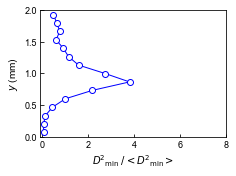

In [7]:
for i_ in range(steps_):
    # import data
    np.load('D:/sheared_granular_gouge_different_evironment_condition/python_nonaffine_displacement_data/nonaffine_of_%s_from_%d_to_%d.npy' % \
            (condition_, index_former_[i_], index_later_[i_]))
    print('\nRead nonaffine from %d to %d done\n' % (index_former_[i_], index_later_[i_]))
    ParticleInfo_former_ = read_ParticleInfo('../particle_info/particle_info_%d.txt', index_former_[i_])
    c_former_ = ParticleInfo_former_[:,[1,2]] # the coordinate of former particles
    c_former_ = c_former_.astype('float64')
    print('\nRead coordinate done\n')
    # screen value to avoid BC
    c_screened_, v_screened_ = screen_grains_by_x(x_lol_, x_upl_, c_former_, nonaffine_)
    # remove extreme value of nonaffine
    cnew_, vnew_ = remove_extreme_value(c_screened_, v_screened_ / np.mean(v_screened_), thresh_, y_lol_, y_upl_)
    # statictics along coordinate y
    centers_, values_ = average_along_y(cnew_[:, 1], vnew_, n_layers_)   
    # plot the results
    plt.figure(figsize=(3.35,2.52))
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rc('font', family = 'Arial')
    plt.rcParams['font.size'] = 9   
    plt.plot(values_, centers_ * 1000 - 1, marker = 'o',markerfacecolor = 'w', linewidth = 1, color = 'b')
    plt.ylim([0,2])
    plt.xlim([-0.1, 8])
    plt.ylabel('$\\mathit{y}$ (mm)', fontsize = 10)
    plt.xlabel('$\\mathit{D}$'+ '$^\\mathrm{2}$' + '$_\\mathrm{min}$' + ' $\\mathrm{/ <}$' + '$\\mathit{D}$'+ '$^\\mathrm{2}$' + '$_\\mathrm{min}$' + '$\\mathrm{>}$', fontsize = 10)
    plt.tight_layout()
    # plt.title('Stick')
#     plt.text( 9, 0.0002, 'Stick')

    plt.savefig('C:/Users/daizh/manuscript_shear_structure_formation_different_conditions/python_file/notebook_plot/average_of_nonaffine_of_%s_from_%d_to_%d.svg' % (condition_, index_former_[i_], index_later_[i_]), format='svg')
    plt.show()